In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt

# NetworkX for graph handling
import networkx as nx

# Torch and PyTorch Geometric for graph-based learning
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import from_networkx, add_self_loops, degree

# SciPy for handling matrix files
from scipy.io import mmread

In [2]:
# this may take a while
a = mmread('datasets/socfb-Harvard1/socfb-Harvard1.mtx')
G = nx.Graph(a)

In [3]:
n_nodes = len(G.nodes)
n_nodes

15126

In [4]:
# this also may take a while
edge_index = from_networkx(G).edge_index

In [5]:
edge_index.shape

torch.Size([2, 1649234])

In [6]:
class BeliefMessagePassing(MessagePassing):
    """
    Implements a message-passing mechanism for belief propagation in a network.

    This model simulates how beliefs spread over a network based on neighbors' 
    beliefs and an individual's openness to external influence.

    Attributes:
        linear (torch.nn.Linear): A linear transformation applied to aggregated messages.
        num_timesteps (int): Number of propagation steps in the message-passing process.
    """

    def __init__(self, in_channels=1, out_channels=1, num_timesteps: int = 5):
        """
        Initializes the belief propagation model.

        Args:
            in_channels (int): Dimensionality of input node features. Defaults to 1.
            out_channels (int): Dimensionality of transformed node features. Defaults to 1.
            num_timesteps (int, optional): Number of message-passing iterations. Defaults to 5.
        """
        super().__init__(aggr='mean')  # Use mean aggregation of messages
        self.linear = torch.nn.Linear(in_channels, out_channels)
        self.num_timesteps = num_timesteps

    def forward(self, x, edge_index, alpha_matrix=None):
        """
        Forward pass for belief propagation.

        Args:
            x (torch.Tensor): Node feature matrix of shape (num_nodes, in_channels).
            edge_index (torch.Tensor): Graph connectivity in COO format.
            alpha_matrix (torch.Tensor, optional): Openness values for each node. Shape: (num_nodes, 1).

        Returns:
            torch.Tensor: Updated node features after belief propagation.
            list[torch.Tensor]: List of node embeddings over time.
        """
        # Add self-loops to ensure that each node retains its original information
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Compute degree normalization (symmetric normalization)
        row, col = edge_index
        deg = degree(row, num_nodes=x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0  # Handle isolated nodes
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]  # Symmetric normalization

        # Initialize alpha_matrix (openness) if not provided
        if alpha_matrix is None:
            alpha_matrix = torch.rand((x.size(0), 1))  # Random openness values

        # Store belief embeddings at each timestep
        embeddings_over_time = [x.clone().detach()]

        # Message passing for multiple timesteps
        for _ in range(self.num_timesteps):
            x = self.propagate(edge_index, x=x, norm=norm, alpha_matrix=alpha_matrix)
            embeddings_over_time.append(x.clone().detach())

        return x, embeddings_over_time

    def message(self, x_j, norm):
        """
        Message function that applies degree normalization to incoming messages.

        Args:
            x_j (torch.Tensor): Features of neighboring nodes.
            norm (torch.Tensor): Degree normalization factor.

        Returns:
            torch.Tensor: Normalized messages.
        """
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out, x, alpha_matrix):
        """
        Update function that determines how beliefs change based on neighbors' beliefs.

        Args:
            aggr_out (torch.Tensor): Aggregated messages from neighbors.
            x (torch.Tensor): Current node beliefs.
            alpha_matrix (torch.Tensor): Openness values for each node.

        Returns:
            torch.Tensor: Updated belief values.
        """
        # Compute similarity between a node's current belief and the aggregated belief from neighbors
        similarity = torch.cosine_similarity(aggr_out, x, dim=-1, eps=1e-6).unsqueeze(-1)

        # Compute updated belief: a node is influenced by neighbors' beliefs based on similarity
        updated_belief = similarity * self.linear(aggr_out) + (1 - similarity) * x

        # Final belief update incorporating openness (alpha_matrix)
        return torch.tanh(alpha_matrix * updated_belief + (1 - alpha_matrix) * x)

**Note:** I was too lazy to code the population generator so I just GPTed this. Some of the distributions missing are uniform distribution for beliefs and bimodal distributions for openness.

In [7]:
class PopulationGenerator:
    def __init__(self, G: nx.Graph, 
                 belief_dist="normal", openness_dist="uniform", 
                 belief_params=None, openness_params=None):
        """
        Initialize the population generator.

        Parameters:
        - G (nx.Graph): The network graph.
        - belief_dist (str): Type of belief distribution ("normal", "bimodal", "beta").
        - openness_dist (str): Type of openness distribution ("uniform", "normal", "beta").
        - belief_params (dict): Parameters for belief distribution.
        - openness_params (dict): Parameters for openness distribution.
        """
        self.G = G
        self.belief_dist = belief_dist
        self.openness_dist = openness_dist
        self.belief_params = belief_params if belief_params else {}
        self.openness_params = openness_params if openness_params else {}

    def generate_beliefs(self, num_nodes):
        """Generates belief values based on the selected distribution."""
        if self.belief_dist == "normal":
            mean = self.belief_params.get("mean", 0)
            std = self.belief_params.get("std", 0.5)
            beliefs = np.random.normal(loc=mean, scale=std, size=num_nodes)

        elif self.belief_dist == "bimodal":
            size1 = num_nodes // 2
            size2 = num_nodes - size1
            beliefs = np.concatenate([
                np.random.normal(loc=-0.8, scale=0.2, size=size1),
                np.random.normal(loc=0.8, scale=0.2, size=size2)
            ])

        elif self.belief_dist == "beta":
            a = self.belief_params.get("a", 5)
            b = self.belief_params.get("b", 2)
            beliefs = 2 * np.random.beta(a, b, size=num_nodes) - 1  # Scale to [-1,1]

        else:
            raise ValueError("Unsupported belief distribution type!")

        return np.clip(beliefs, -1, 1)  # Clip between -1 and 1

    def generate_openness(self, num_nodes):
        """Generates openness values based on the selected distribution."""
        if self.openness_dist == "uniform":
            a = self.openness_params.get("a", 0.1)
            b = self.openness_params.get("b", 0.9)
            openness = np.random.uniform(a, b, size=num_nodes)

        elif self.openness_dist == "normal":
            mean = self.openness_params.get("mean", 0.5)
            std = self.openness_params.get("std", 0.1)
            openness = np.random.normal(loc=mean, scale=std, size=num_nodes)

        elif self.openness_dist == "beta":
            a = self.openness_params.get("a", 2)
            b = self.openness_params.get("b", 5)
            openness = np.random.beta(a, b, size=num_nodes)  # Beta is naturally [0,1]

        else:
            raise ValueError("Unsupported openness distribution type!")

        return np.clip(openness, 0, 1)  # Openness should always be in [0,1]

    def generate(self):
        """Generates the population and returns belief and openness tensors."""
        num_nodes = len(self.G.nodes)

        # Generate beliefs and openness
        beliefs = self.generate_beliefs(num_nodes)
        openness = self.generate_openness(num_nodes)

        # Convert to PyTorch tensors
        x = torch.from_numpy(beliefs).float().view(-1, 1)  # Belief tensor
        alpha_matrix = torch.from_numpy(openness).float().view(-1, 1)  # Openness tensor

        return x, alpha_matrix

# Belief and Openness Distributions

**Note: I was also too lazy to explain the distributions so I had GPT do this too. Some of the distribution options it lists here might not be available in the population generator class.**

When modeling belief and openness in a network, different probability distributions can be used to reflect various societal or structural influences on how beliefs form and spread. Below are several distribution types and their appropriate use cases.

## 1. **Normal Distribution**
   - **Description**: A unimodal, symmetric distribution where most values cluster around the mean, with fewer extreme values.
   - **When to Use**: 
     - When belief formation is influenced by multiple small, independent factors.
     - In environments where beliefs follow a natural tendency toward moderate positions, with fewer extreme believers or disbelievers.
     - When openness levels are normally distributed due to social and cognitive diversity.

## 2. **Bimodal Distribution**
   - **Description**: A distribution with two peaks, representing two dominant groups of belief (e.g., strong believers and strong disbelievers).
   - **When to Use**: 
     - When the population is polarized, possibly due to confirmation bias, echo chambers, or media influence.
     - In scenarios where social or algorithmic reinforcement leads to a lack of moderate perspectives.
     - If openness is similarly polarized, where one group is highly open and another is very closed.

## 3. **Beta Distribution (Skewed)**
   - **Description**: A flexible distribution that can be skewed toward one extreme (e.g., most people leaning toward belief or disbelief).
   - **When to Use**:
     - When belief formation is dominated by strong external influences like political, religious, or cultural indoctrination.
     - In cases where the majority leans toward one view, but a minority still holds an opposing belief.
     - When openness is shaped by a dominant cultural norm, where most people are either highly open or highly closed.

## 4. **Uniform Distribution**
   - **Description**: A flat distribution where all values are equally likely.
   - **When to Use**: 
     - When beliefs are initialized randomly without any inherent bias.
     - In experimental setups where no prior assumption is made about how belief is distributed.
     - When modeling openness in an unpredictable or chaotic environment.

Each of these distributions provides a different lens for modeling how belief and openness are structured in a population. The choice of distribution should be guided by empirical data or theoretical considerations based on the environment being simulated.


In [8]:
# default population belief distribution is normal and openness distribution is uniform, we can change this tbh so that both are normal or to adapt openness based on other studies we can find
# the generator is also already monte-carlo-ed since it randomly generates a new kind of population each time
pop_gen = PopulationGenerator(G)
x, alpha_matrix = pop_gen.generate()

model = BeliefMessagePassing(in_channels=1, out_channels=1, num_timesteps=20)
final, over_time = model(x, edge_index, alpha_matrix)

Run the cell below to graph out the believers at each time step

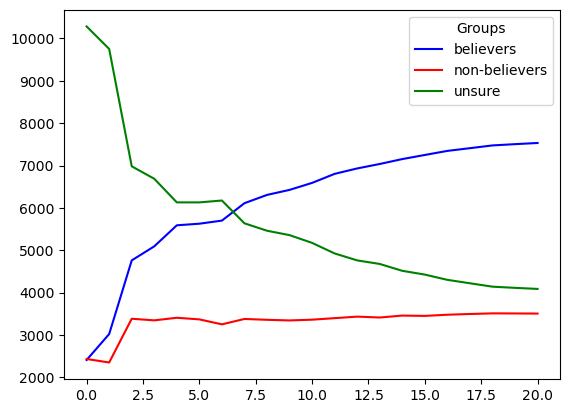

In [9]:
believers_over_time = []
nonbelievers_over_time = []
moderates_over_time = []

for timestep in over_time:
    believers = (timestep > 0.5).sum(dim=0)
    believers_over_time.append(believers)

    nonbelievers = (timestep <-0.5).sum(dim=0)
    nonbelievers_over_time.append(nonbelievers)

    total_pop = len(G.nodes)
    moderates_over_time.append(total_pop - (nonbelievers + believers))

fig, ax = plt.subplots()
ax.plot(range(0,model.num_timesteps+1), believers_over_time, color='blue', label='believers')
ax.plot(range(0,model.num_timesteps+1), nonbelievers_over_time, color='red', label='non-believers')
ax.plot(range(0,model.num_timesteps+1), moderates_over_time, color='green', label='unsure')
ax.legend(title='Groups', loc='upper right')

# TODO:
* Implement different scenarios in the PopulationGenerator class like:
  * echo-chambers where people with similar beliefs tend to be more connected and a node's belief is closer to the average of its neighbors; or
  * polarized groups where there is a strong division between two opposing groups
* Implement closeness (Optional):
  * edge labels that indicate how "close" an individual is with another person with the assumption that you are more likely to believe / entertain someone you are closer to